# Basics of using NumPy and Matplotlib

In this tutorial, we will go through basics of NumPy and Matplotlib for manipulating multi-dimensional images. We will use a dynamic MRI dataset as an example. Part of the tutorial is based on Stefan van der Walt's teaching materials in [ImageXD 2018](https://github.com/stefanv/teaching/tree/master/2018-imagexd_scientific_python) and [ASPP 2018](https://github.com/stefanv/teaching/tree/master/2018_aspp_melbourne_numpy), and Matplotlib's [Anatomy of Matplotlib](https://github.com/matplotlib/AnatomyOfMatplotlib).


# Familiarize yourself with the jupyter notebook environment

- Two modes: navigate & edit (use the keyboard! Shift-Enter to run cell)
- Help: `?`
- Tab completion
- Docstring inspection: `np.some_fun?` and `np.some_fun??`
- Magic commands: `%timeit`, `%run`

In [3]:
?

# Import NumPy

In [4]:
import numpy as np  # We always use this convention,
                    # also in the documentation

# Load array

To start, we will use a cardiac MRI dataset. The dataset has shape (30, 144, 144). The dimensions are ordered as time, y, and x.

Let us load the dataset first and look at its shape:

In [7]:
img = np.load('data/cardiac.npy')

img.shape, img.size, img.dtype

((30, 144, 144), 622080, dtype('float32'))

One feature of NumPy arrays is that it can provide views of the underlying array without copying the array.  For example, to get the first frame of the image, we can do

    img[0]
    
which extracts the first frame without copying.

In [8]:
img_0 = img[0]

img_0.shape

(144, 144)

# Plot image

An important part of computational imaging is to look at the images. So let us go through some basics of the plotting library `matplotlib`.

Matplotlib has multiple "backends" that handle converting Matplotlib's in-memory representation of your plot into the colorful output you can look at. For jupyter notebooks, we will use a matplotlib magic to choose the `'nbagg'` backend and import matplotlib.pyplot.

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt  # by convention

Adn we can plot the image slice with the following command:

<IPython.core.display.Javascript object>


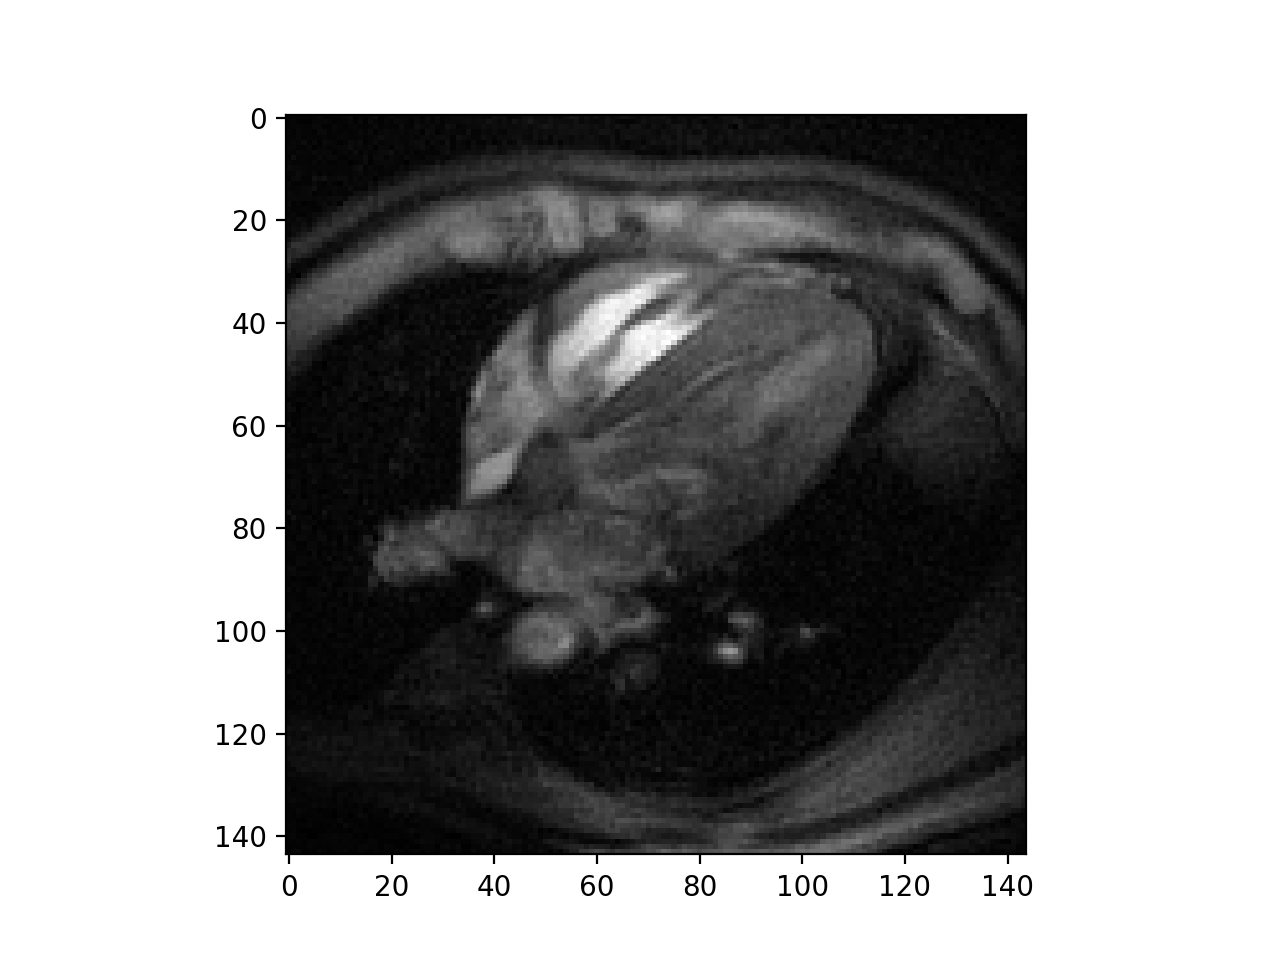

In [14]:
fig, ax = plt.subplots()
ax.imshow(img_0, cmap='gray')

# Details about Matplotlib

Let us explain what `fig` and `ax` are.

<img src="images/figure_axes_axis_labeled.png" width="50%">

`fig` is a ``Figure`` object. The ``Figure`` is the top-level container in this hierarchy.  It is the overall window/page that everything is drawn on.  You can have multiple independent figures and ``Figure``s can contain multiple ``Axes``. 

`ax` is an ``Axes`` object. Most plotting ocurs on an ``Axes``.  The axes is effectively the area that we plot data on and any ticks/labels/etc associated with it.  Usually we'll set up an Axes with a call to ``subplot`` (which places Axes on a regular grid), so in most cases, ``Axes`` and ``Subplot`` are synonymous.

Each ``Axes`` has an ``XAxis`` and a ``YAxis``.  These contain the ticks, tick locations, labels, etc.  In this tutorial, we'll mostly control ticks, tick labels, and data limits through other mechanisms, so we won't touch the individual ``Axis`` part of things all that much.  However, it is worth mentioning here to explain where the term ``Axes`` comes from.

# Plot through time

<IPython.core.display.Javascript object>


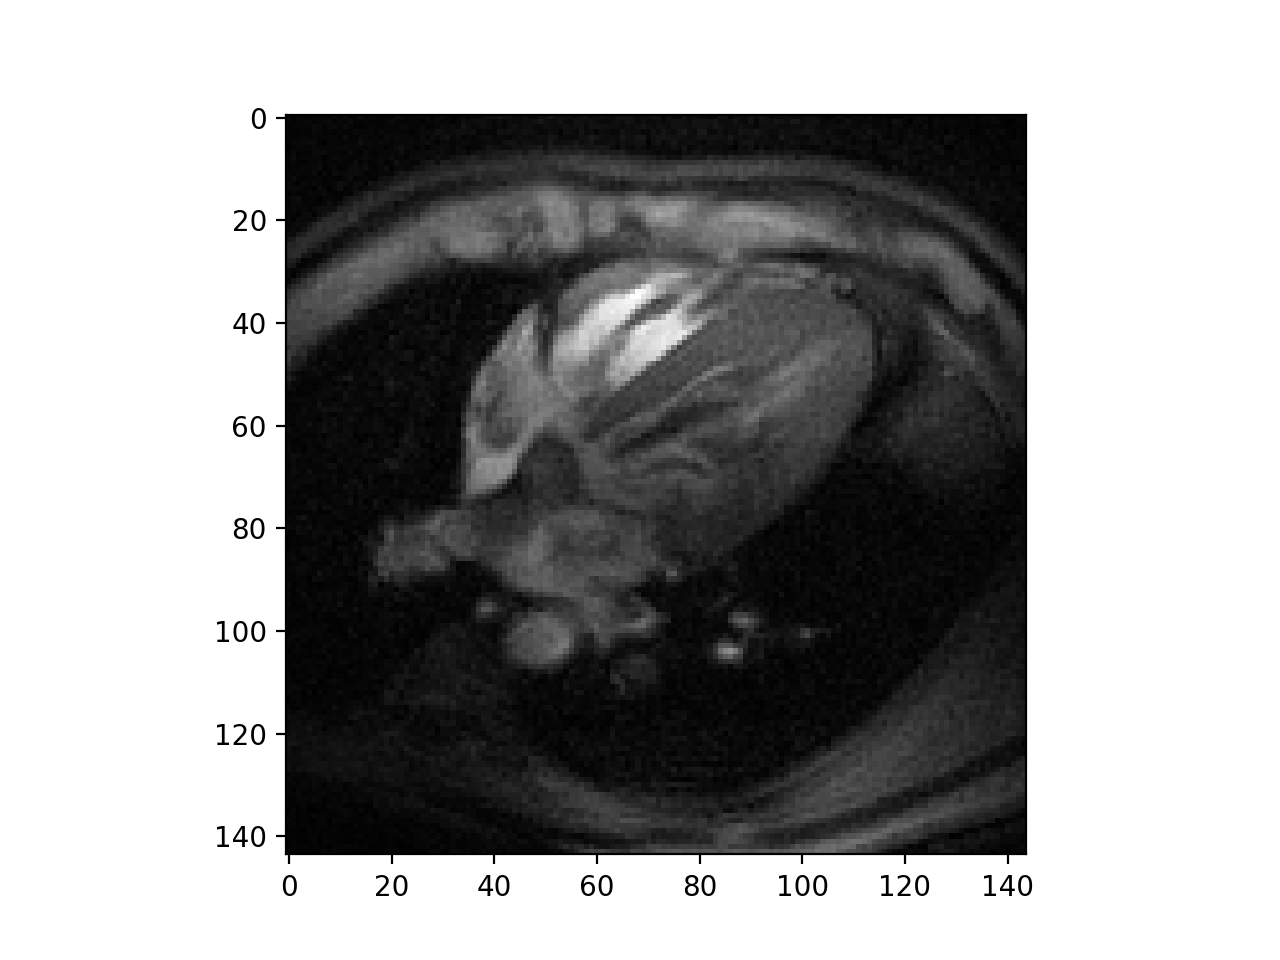

In [15]:
fig, ax = plt.subplots()
for t in range(30):
    ax.cla()
    ax.imshow(img[t], cmap='gray')
    fig.canvas.draw()

# Slice temporal profile

We are often interested in the temporal profile to look at the sharpness of the reconstruction. For example, if we are interested in the temporal profile at $x = 75$, we can create a view as

<IPython.core.display.Javascript object>


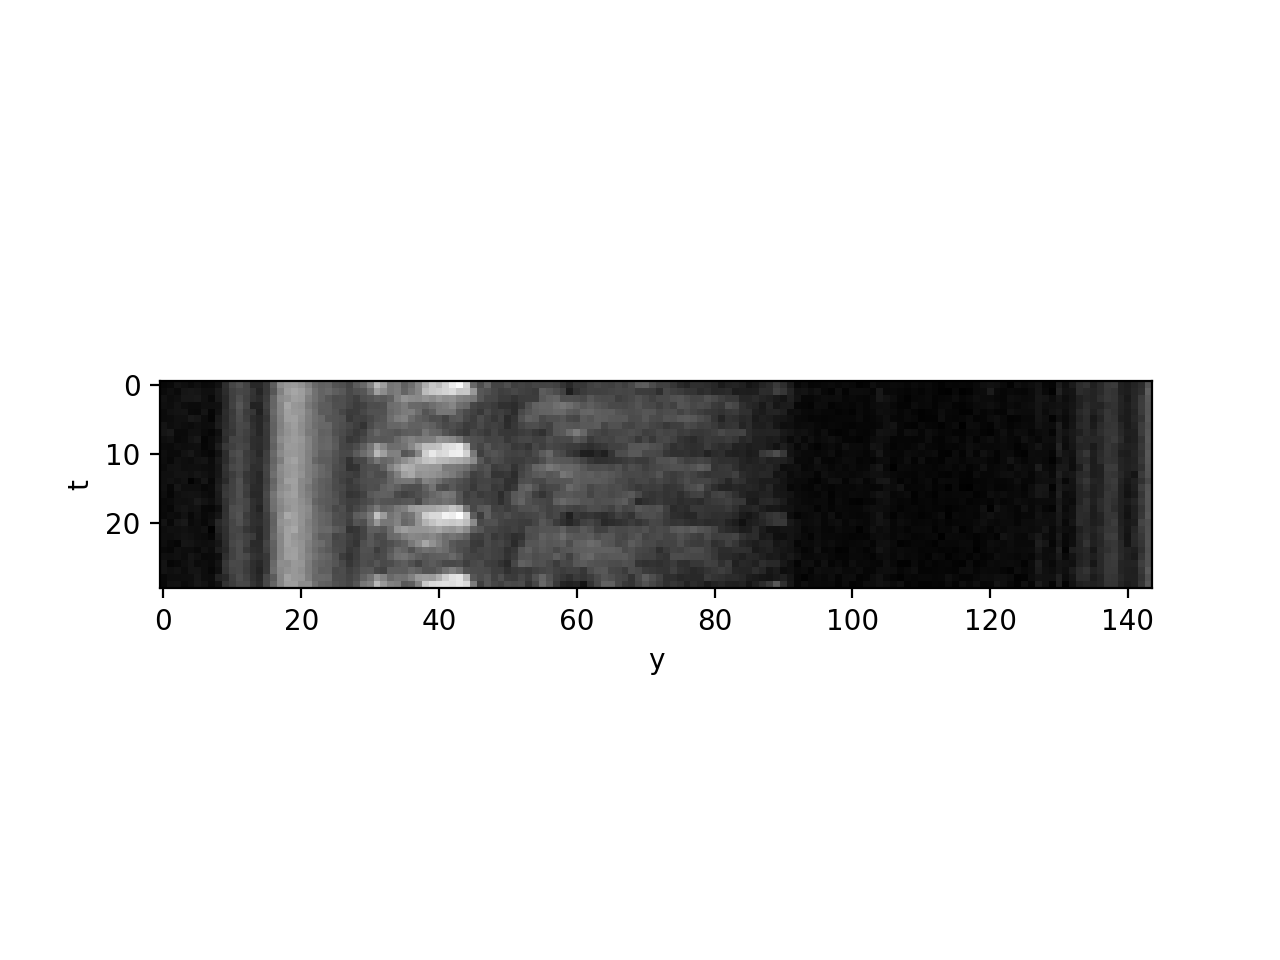

Text(0, 0.5, 't')

In [16]:
time_profile = img[:, :, 75]

fig, ax = plt.subplots()
ax.imshow(time_profile, cmap='gray')
ax.set_xlabel('y')
ax.set_ylabel('t')

It is often customary to put time progression horizontally. We can transpose the image using ``.T``

<IPython.core.display.Javascript object>


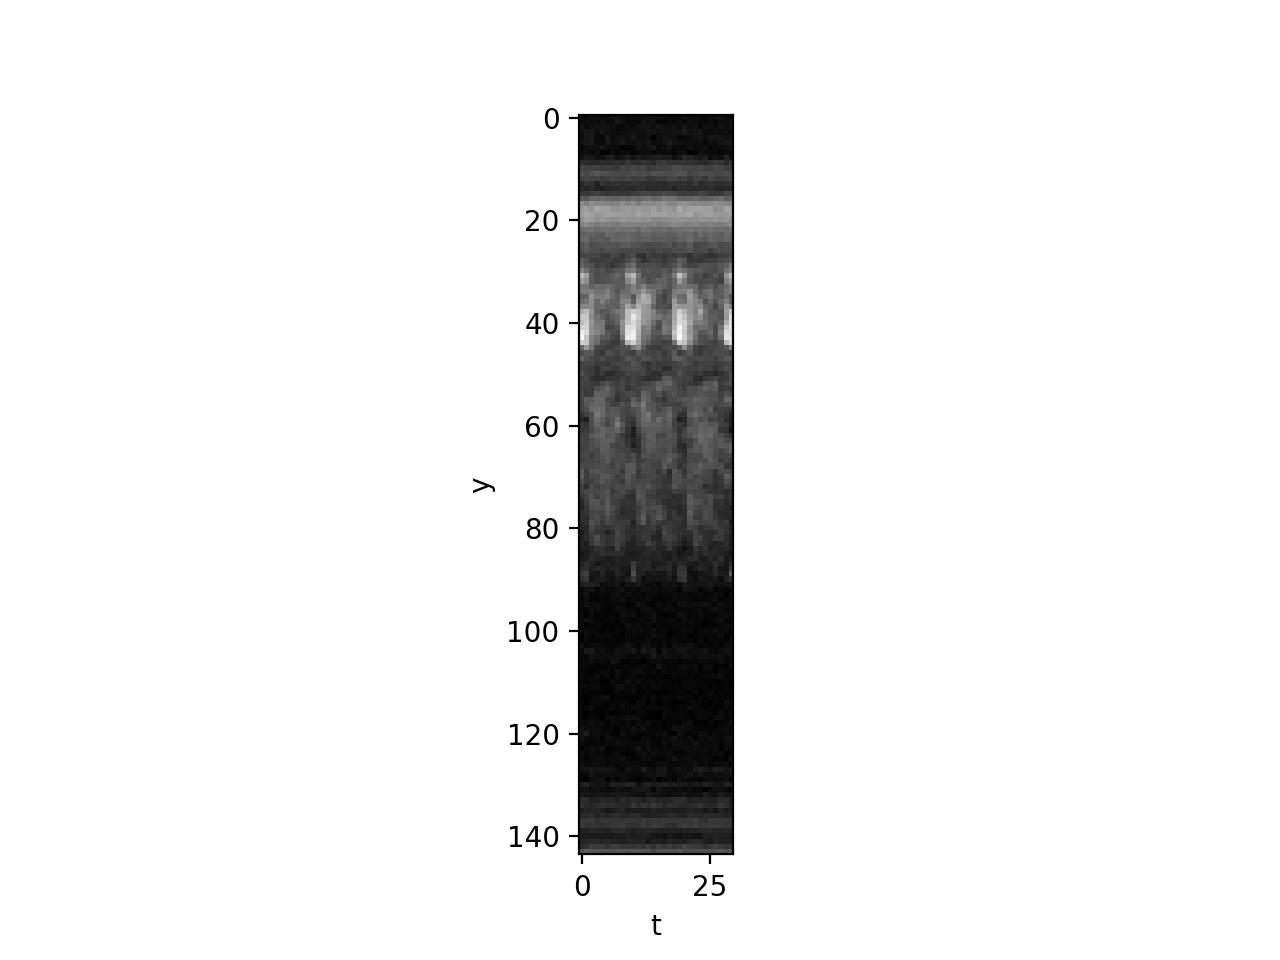

Text(0, 0.5, 'y')

In [17]:
time_profile = img[:, :, 75].T

fig, ax = plt.subplots()
ax.imshow(time_profile, cmap='gray')
ax.set_xlabel('t')
ax.set_ylabel('y')

Note that none of the above operations created any additional arrays. All slices were simply views to the original image ``img``.

In fact, if we scale ``time_profile`` by 2, then ``img`` will have a line scaled by 2.

In [ ]:
time_profile *= 2

fig, ax = plt.subplots()
ax.imshow(img[0], cmap='gray')

Let us scale it back.

In [ ]:
time_profile /= 2

fig, ax = plt.subplots()
ax.imshow(img[0], cmap='gray')

# Temporal smoothing using FFT and Broadcasting

If you look at the images closely, you would see that it still has some noise. One way to get rid of the noise is to smooth along time.

We will do that by doing a Fourier transform along time and multiplying with a hanning window.

Here's how you can do a centered FFT along time:

In [20]:
img_shift = np.fft.ifftshift(img, axes=0)
imgf_shift = np.fft.fft(img_shift, axis=0)
imgf = np.fft.fftshift(imgf_shift, axes=0)

<IPython.core.display.Javascript object>


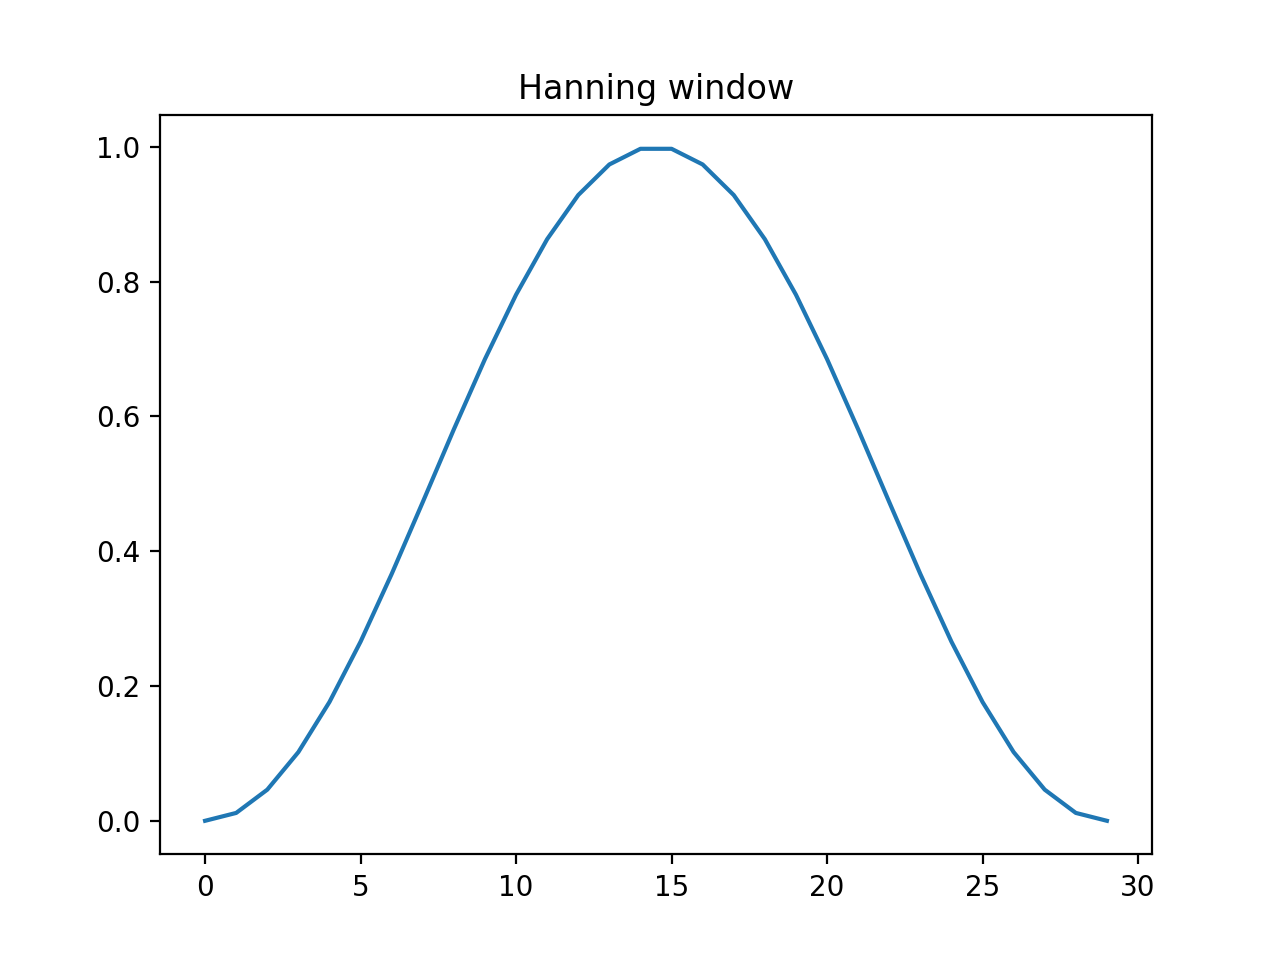

Text(0.5, 1.0, 'Hanning window')

In [23]:
window = np.hanning(30)

fig, ax = plt.subplots()
ax.plot(window)
ax.set_title('Hanning window')

Now we would like to multiply `imgf` with `window`. However, `imgf.shape = (30, 144, 144)` does not match with `window.shape = (30, )`. Instead of replicating `window` to have shape `(30, 144, 144)`, we will make use of broadcasting.

Here's what we do

In [27]:
imgf *= window.reshape((30, 1, 1))

Internally, NumPy tries to figure out the output shape by doing
```
imgf shape   = (30, 144, 144)
window shape = (30,   1,   1)
-------------------
imgf shape   = (30, 144, 144)
```

Let us do a centered IFFT and look at the images.

<IPython.core.display.Javascript object>


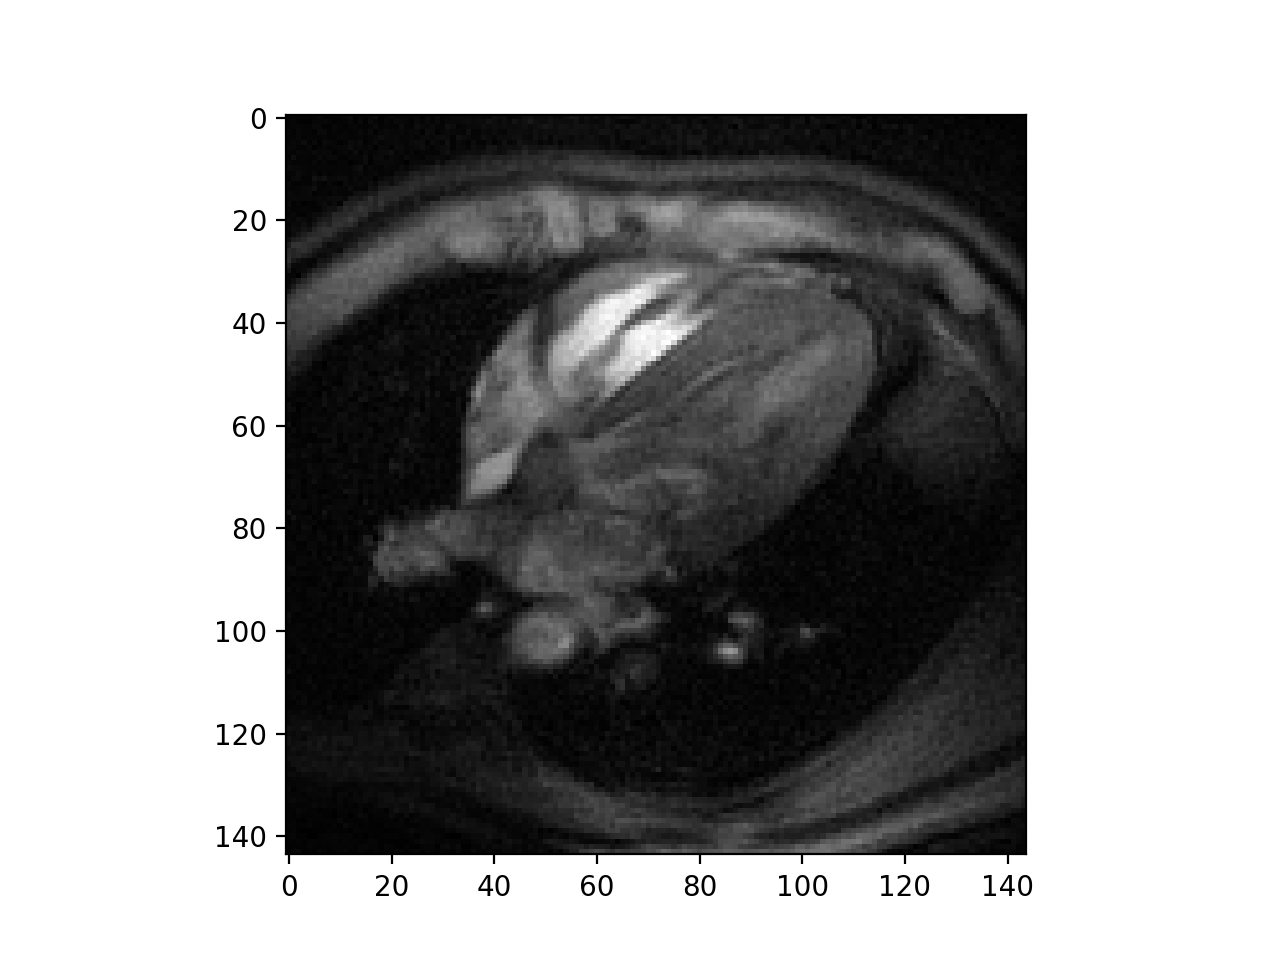

<IPython.core.display.Javascript object>


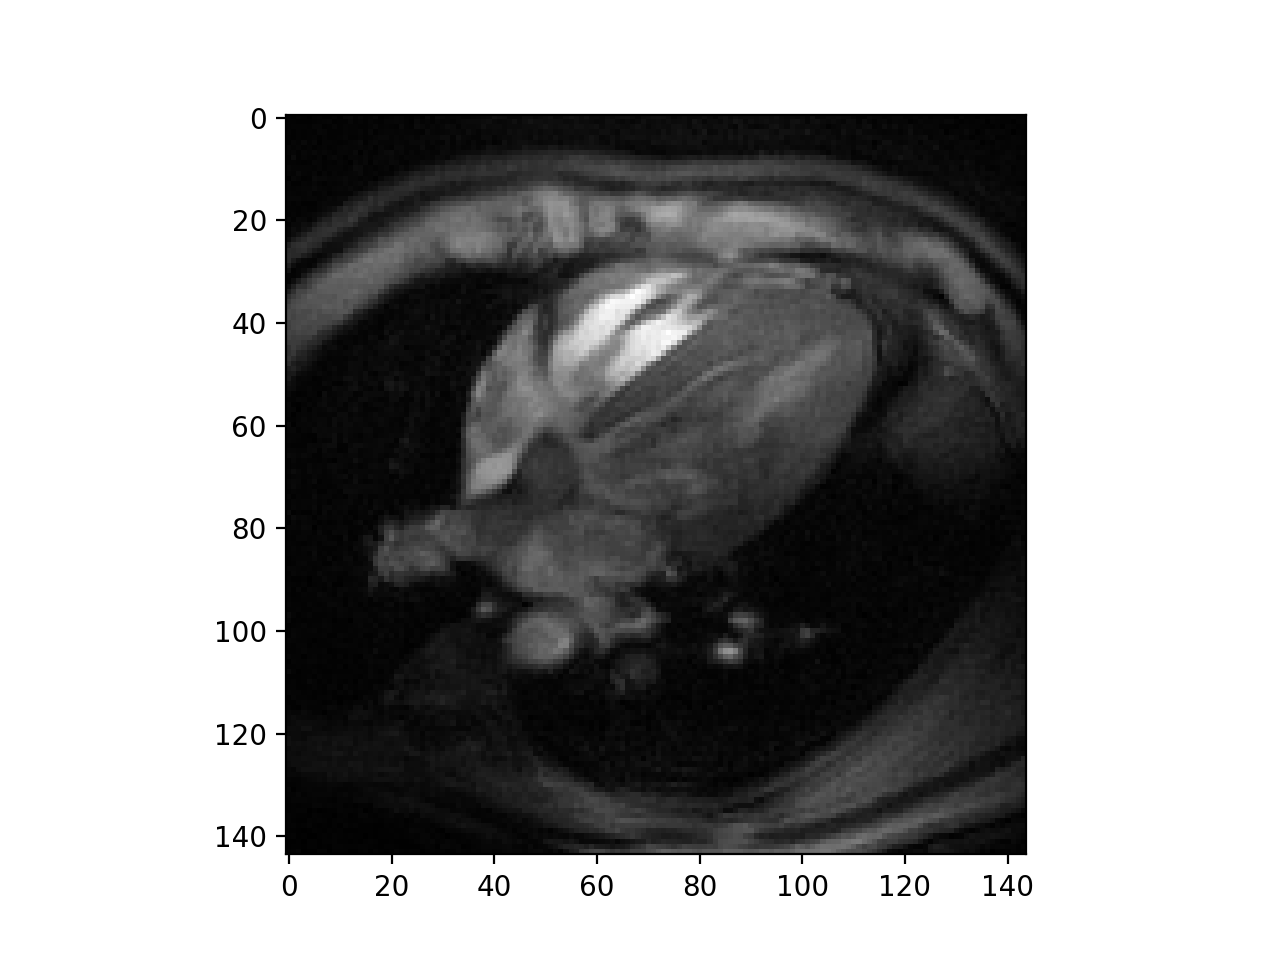

In [28]:
imgf_shift = np.fft.ifftshift(imgf, axes=0)
img_shift = np.fft.ifft(imgf_shift, axis=0)
img_rec = np.fft.fftshift(img_shift, axes=0)
img_rec = np.abs(img_rec)

fig, ax = plt.subplots()
ax.imshow(np.abs(img[0]), cmap='gray')

fig, ax = plt.subplots()
ax.imshow(np.abs(img_rec[0]), cmap='gray')

<IPython.core.display.Javascript object>


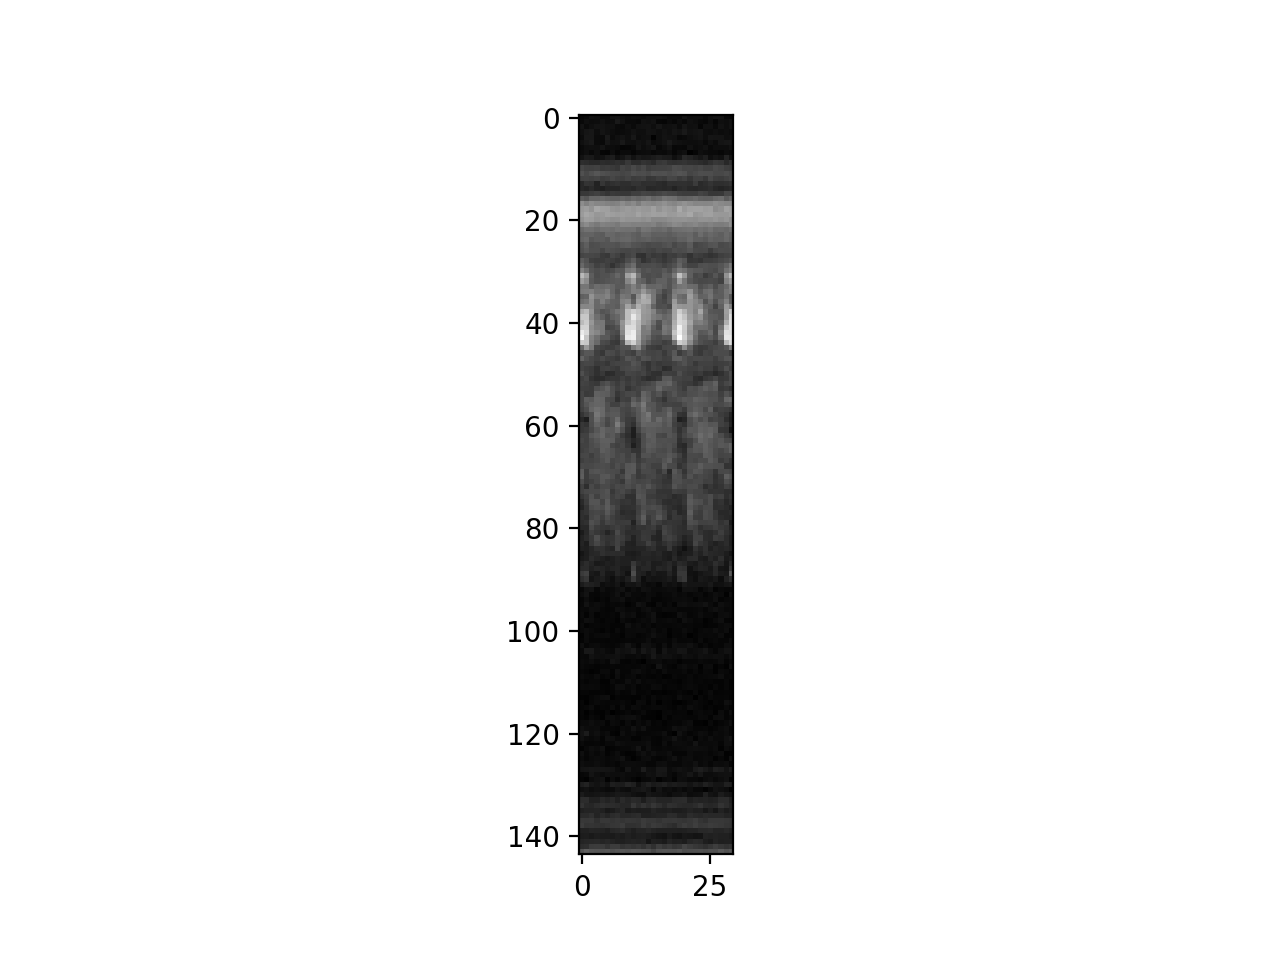

<IPython.core.display.Javascript object>


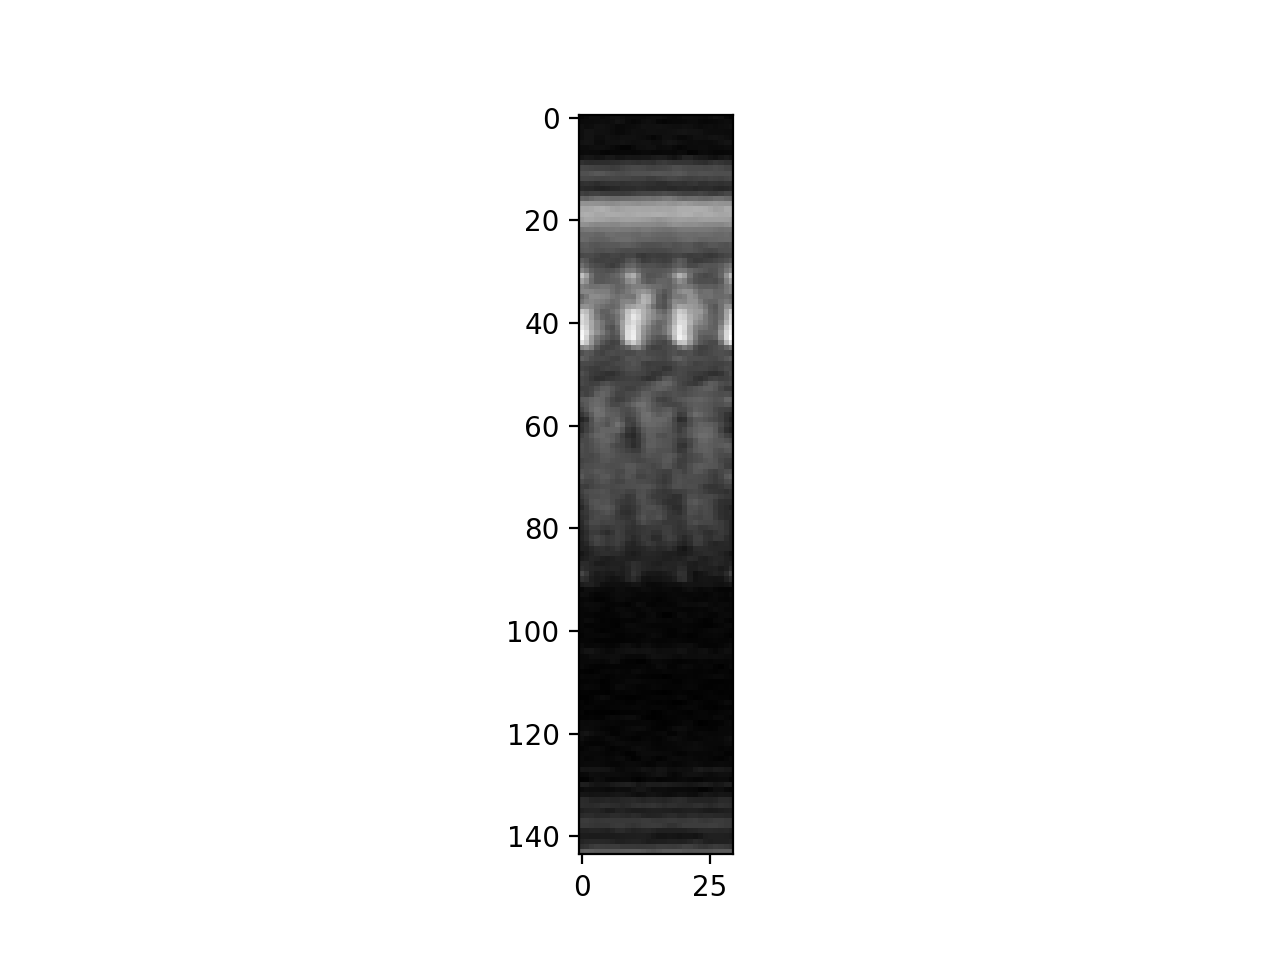

In [29]:
time_slice = img[:, :, 75].T
time_slice_rec = img_rec[:, :, 75].T

fig, ax = plt.subplots()
ax.imshow(time_slice, cmap='gray')

fig, ax = plt.subplots()
ax.imshow(time_slice_rec, cmap='gray')

# Details about NumPy Array

We wrap up by taking a look at ``numpy/core/include/numpy/ndarraytypes.h``:

```cpp
ndarray typedef struct PyArrayObject {
    PyObject_HEAD
    char *data;             /* pointer to data buffer */
    int nd;                 /* number of dimensions */
    npy_intp *dimensions;   /* size in each dimension */
    npy_intp *strides;      /* bytes to jump to get
                             * to the next element in
                             * each dimension
                             */
    PyObject *base;         /* Pointer to original array
                            /* Decref this object */
                            /* upon deletion. */
    PyArray_Descr *descr;   /* Pointer to type struct */
    int flags;              /* Flags */
    PyObject *weakreflist;  /* For weakreferences */
} PyArrayObject ;
```

NumPy Array essentially describes memory using the following attributes:

- **Data pointer** the memory address of the first byte in the array.
- **Data type** description the kind of elements contained in the array, for example floating point numbers or integers.
- **Shape** the shape of the array, for example (10, 10) for a ten-by-ten array, or (5, 5, 5) for a block of data describing a mesh grid of x-, y- and z-coordinates.
- **Strides** the number of bytes to skip in memory to proceed to the next element. For a (10, 10) array of bytes, for example, the strides may be (10, 1), in other words: proceed one byte to get to the next column and ten bytes to locate the next row.
- **Flags** which define whether we are allowed to modify the array, whether memory layout is C- or Fortran-contiguous, and so forth.


<img src="images/ndarray_struct.png"/>

This allows us to reshape and slice multi-dimensional arrays by setting shape, strides and flags appropriately.

<img src="images/array_memory_presentation.png" width="80%"/>